## Goal
In this notebook, we apply the Intelligent search methods like Differential Evolution Algorithm to find the best ML algorithm hyper-parameters. 
Previous options are using either predetermined or randomly generated parameters for the ML algorithms. 
Some of these searching methods are actually a simulation of Intelligent agents in nature like the folk of birds or school of fishes.

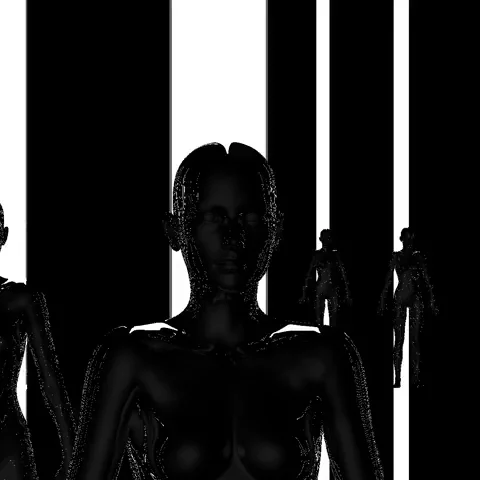

* GIF Ref: https://giphy.com/gifs/c4d-human-ai-8hYQgBIIHkCPjRTmai

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import plotly.express as px

## Searching Algorithm of your choice 
Lets use DE Algorithm.
* Reference for algorithm codes: https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/# 


In [ ]:
def De_Algorithm(fobj, bounds, mut=0.8, crossp=0.7, popsize=100, its=1000):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
                    
        #print("Iteration number= %s" % (i))
        #print("Best Fitness= %s" % (fitness[best_idx]))
        #print("Best values= %s" % (best))
        yield best, fitness[best_idx]

## ML algorithm of your choice
Let's use the most Common ML Competition algorithm which is XGBoost.

In [ ]:
def xgb2(X_training, y_training, X_valid, y_valid, w):
    
    w[1] = round(w[1])
    w[2] = round(w[2])
    w[6] = round(w[6])
    w[7] = round(w[7])
    w[8] = round(w[8])
    w[9] = round(w[9])
    w[10] = round(w[10])
    
    params = {'eta': w[0], # 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': w[1], # 1400,  
          'max_depth': w[2], # 0, 
          'subsample': w[3], # 0.9, 
          'colsample_bytree': w[4], # 0.7, 
          'colsample_bylevel': w[5], # 0.7,
          'min_child_weight': w[6], # 0,
          'alpha': w[7], # 4,
          'objective': 'reg:logistic', 
          'scale_pos_weight': w[8], # 9,
          'eval_metric': 'auc', 
          'nthread': w[9], # 8,
          'random_state': w[10], # 99, 
          'silent': True}
    
    dtrain = xgb.DMatrix(X_training, y_training)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(params, dtrain, 1000, watchlist, maximize=True, early_stopping_rounds = 500, verbose_eval=1)
    
    # make predictions for test data
    X_valid = xgb.DMatrix(X_valid)
    y_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
    rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
    #print("RMSE: %f" % (rmse))
    
    return model, rmse

## Data-set of your choice
Let's use the TalkingData set which is available on Kaggle.

In [ ]:
address_train = '../input/newdataamin/data.csv'

### Some handy functions

In [ ]:
def Drop_cols(df, x):
    df.drop(labels = x, axis = 1, inplace = True)
    return df

def Plot_Hist_column(df, x):
    pyplot.hist(df[x], log = True)
    pyplot.title(x)
    pyplot.show()
    
def Plot_Hist_columns(df, xlist):
    [Plot_Hist_column(df, x) for x in xlist]  
    pyplot.show()
    
def Make_X_Y(df):
    Y = pd.DataFrame()
    Y['Real density (gr/cc)'] = df['Real density (gr/cc)']
    X = df.copy()
    X.drop(labels = ["Real density (gr/cc)"], axis = 1, inplace = True)
    return X, Y

def Train_Test_training_valid(X, Y, ratio):
    Num_of_line = 100
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ratio)
    X_training, X_valid, y_training, y_valid = \
    train_test_split(X_train, y_train, test_size=ratio, random_state=0)
    return X_training, y_training, X_valid, y_valid

def Merge_data(df1, df2):
    frames = [df1, df2]
    df = pd.concat(frames)
    return df

## Preparing a dataset
read data balanced. Read all 1 values from the train data set and then add the same number of 0 and keep it. Now we do have a balance data set with an equal number of 0 and 1.

In [ ]:
#df_train = read_train_test_data_balanced(address_train)
df_train = pd.read_csv(address_train)
df_train.head(3)

In [ ]:
# See the output paramters distribution 
xlist = ['Real density (gr/cc)']
Plot_Hist_columns(df_train, xlist)

In [ ]:
fig = px.scatter_matrix(df_train, width=800, height=800)
fig.show()

In [ ]:
df = df_train.head(30)
fig = px.parallel_categories(df, color="Real density (gr/cc)", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

In [ ]:
sns.set()
columns = ['Mw','Tpr','Ppr','Real density (gr/cc)']
sns.pairplot(df_train[columns],size = 2.4 ,kind ='scatter',diag_kind='kde')#,hue=" Real density (gr/cc)")
plt.show()

In [ ]:
# Devide data set to input (X) and output (Y) paramters.
X, Y = Make_X_Y(df_train); 
X_training, y_training, X_valid, y_valid = Train_Test_training_valid(X, Y, 0.02)

In [ ]:
w = [0.2, 400, 10, 0.9, 0.7, 0.7, 0, 4, 9, 8, 99]
model2, rmse = xgb2(X_training, y_training, X_valid, y_valid, w)

In [ ]:
#Define an objective funtion.
def Objective_Function2(w):
    w = w.tolist()
    model2, rmse = xgb2(X_training, y_training, X_valid, y_valid, w)
    return (rmse)

In [ ]:
#Run the DE algorithm on objective function in your favorite range of hyperparameters.
result = list(De_Algorithm(Objective_Function2,
                 [(0.001,5),   #  eta
                  (3,4500),   #  max_leaves
                  (0,40),   #  max_depth
                  (0,1),   #  subsample
                  (0.001,1),   #  colsample_bytree
                  (0.001,1),   #  colsample_bylevel
                  (0.001,1),   #  min_child_weight
                  (2,20),   #  alpha
                  (1,10),   # scale_pos_weight
                  (1,20),     # nthread
                  (1,100)], #  random_state
                  mut=0.7, crossp=0.8, popsize=10, its=150))

In [ ]:
df = pd.DataFrame(result)
# seperate the best of hyperparamters.
def Best_coffs(df):
    
    #df['w1'], df['w2'], df['w3'], df['w4'], df['w5'], df['w6'], df['w7'], df['w8'], df['w9']   = zip(*df[0]) # Unzip
    df['w1'], df['w2'], df['w3'], df['w4'], df['w5'], df['w6'], df['w7'], df['w8'], df['w9'], df['w10'], df['w11']   = zip(*df[0]) # Unzip
    cols = [0] # Drop the first column
    df.drop(df.columns[cols],axis = 1,inplace = True) # Drop the first column
    df.columns.values[0] = "Fitness" # name the first column as Fitness
    best_coff = df.iloc[len(df)-1,1:] # insert the best coefficients into the best_coff
    return best_coff
Best_coffs(df)

In [ ]:
def Plot_DEA_Evolution(df):
    
    data_ncol=len(df.columns) # number of paramters 
    fig = plt.figure(figsize=(20,15)) # you may change these to change the distance between plots.

    for i in range(1,(data_ncol+1)):
        if i<(data_ncol):
            
            plt.subplot(3, 4, i)
            plt.plot(df['w{}'.format(i)],'bo', markersize=4)
            plt.xlabel('Iteration')
            plt.ylabel('w{}'.format(i))
            plt.grid(True)
        else:       
            plt.subplot(3, 4, data_ncol)
            plt.plot(df['Fitness'],'red', markersize=4)
            plt.xlabel('Iteration')
            plt.ylabel('RMSE')
            plt.grid(True)
    plt.show()

## Visualization of searching progress

In [ ]:
Plot_DEA_Evolution(df)

In [ ]:
df = pd.DataFrame(result)
def Best_coffs(df):

    #df['learning_rate'],df['n_estimators'], df['max_depth'],df['min_child_weight'], df['gamma'],df['subsample'], df['colsample_bytree'],df['nthread'], df['scale_pos_weight'] = zip(*df[0]) # Unzip
    df['eta'], df['max_leaves'],df['max_depth'], df['subsample'],df['colsample_bytree'], df['colsample_bylevel'],df['min_child_weight'], df['alpha'],df['scale_pos_weight'], df['nthread'], df['random_state'] = zip(*df[0]) # Unzip
    cols = [0] # Drop the first column
    df.drop(df.columns[cols],axis = 1,inplace = True) # Drop the first column
    df.columns.values[0] = "Fitness" # name the first column as Fitness
    best_Parameters = df.iloc[len(df)-1,1:] # insert the best coefficients into the best_coff

    return best_Parameters

def print_hyper_parameters(df):
    
    best_Parameters = Best_coffs(df)
    best_Parameters[1] = round(best_Parameters[1])
    best_Parameters[2] = round(best_Parameters[2])
    best_Parameters[6] = round(best_Parameters[6])
    best_Parameters[7] = round(best_Parameters[7])
    best_Parameters[8] = round(best_Parameters[8])
    best_Parameters[9] = round(best_Parameters[9])
    best_Parameters[10] = round(best_Parameters[10])
    print(best_Parameters)
    
print_hyper_parameters(df)   

## Train XGBoost using best hyperparamters

In [ ]:
def xgb2(X_training, y_training, X_valid, y_valid, w):
    
    w[1] = round(w[1])
    w[2] = round(w[2])
    w[6] = round(w[6])
    w[7] = round(w[7])
    w[8] = round(w[8])
    w[9] = round(w[9])
    w[10] = round(w[10])
    
    params = {'eta': w[0], # 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': w[1], # 1400,  
          'max_depth': w[2], # 0, 
          'subsample': w[3], # 0.9, 
          'colsample_bytree': w[4], # 0.7, 
          'colsample_bylevel': w[5], # 0.7,
          'min_child_weight': w[6], # 0,
          'alpha': w[7], # 4,
          'objective': 'binary:logistic', 
          'scale_pos_weight': w[8], # 9,
          'eval_metric': 'auc', 
          'nthread': w[9], # 8,
          'random_state': w[10], # 99, 
          'silent': True}
    
    dtrain = xgb.DMatrix(X_training, y_training)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(params, dtrain, 1000, watchlist, maximize=True, early_stopping_rounds = 100, verbose_eval=0)
    
    # make predictions for test data
    X_valid = xgb.DMatrix(X_valid)
    y_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
    rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
    print("RMSE: %f" % (rmse))
    
    return model, rmse

In [ ]:
def xgb2(X_training, y_training, X_valid, y_valid, w):
    
    w[1] = round(w[1])
    w[2] = round(w[2])
    w[6] = round(w[6])
    w[7] = round(w[7])
    w[8] = round(w[8])
    w[9] = round(w[9])
    w[10] = round(w[10])
    
    params = {'eta': w[0], # 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': w[1], # 1400,  
          'max_depth': w[2], # 0, 
          'subsample': w[3], # 0.9, 
          'colsample_bytree': w[4], # 0.7, 
          'colsample_bylevel': w[5], # 0.7,
          'min_child_weight': w[6], # 0,
          'alpha': w[7], # 4,
          'objective': 'reg:logistic', 
          'scale_pos_weight': w[8], # 9,
          'eval_metric': 'auc', 
          'nthread': w[9], # 8,
          'random_state': w[10], # 99, 
          'silent': True}
    
    dtrain = xgb.DMatrix(X_training, y_training)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(params, dtrain, 10000, watchlist, maximize=True, early_stopping_rounds = 1000, verbose_eval=0)
    
    # make predictions for test data
    X_valid = xgb.DMatrix(X_valid)
    y_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
    rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
    print("RMSE: %f" % (rmse))
    
    return model, rmse

In [ ]:
df = pd.DataFrame(result)
w = list(Best_coffs(df))
Trained_Model, rmse = xgb2(X_training, y_training, X_valid, y_valid, w)

In [ ]:
# make predictions for all data
X = xgb.DMatrix(X)
Y_pred = Trained_Model.predict(X, ntree_limit=Trained_Model.best_ntree_limit)

fig = plt.figure(figsize=(10,10))
plt.plot(Y, Y_pred, '.', color='black')
plt.xlabel('Data')
plt.ylabel('Model')
plt.title('Model and Data comparison')
plt.grid(True)

In [ ]:
df_train['Model'] = pd.DataFrame(Y_pred)
fig = px.scatter(df_train, x="Real density (gr/cc)", y="Model", trendline = "ols", width=600, height=600, color="Mw")
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

In [ ]:
df_train['Model'] = pd.DataFrame(Y_pred)
fig = px.scatter(df_train, x="Real density (gr/cc)", y="Model", trendline = "ols", width=600, height=600, color="Tpr")
fig.show()

In [ ]:
df_train['Model'] = pd.DataFrame(Y_pred)
fig = px.scatter(df_train, x="Real density (gr/cc)", y="Model", trendline = "ols", width=600, height=600, color="Ppr")
fig.show()

In [ ]:
# make predictions for all data
X_valid = xgb.DMatrix(X_valid)
Y_pred = Trained_Model.predict(X_valid, ntree_limit=Trained_Model.best_ntree_limit)

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(y_valid, Y_pred, '.', color='black')
plt.xlabel('Data')
plt.ylabel('Model')
plt.title('Model and Data comparison')
plt.grid(True)

In [ ]:
df_train.to_csv('Amin_csv_to_submit1.csv', index = False)

In [ ]:
df_train_valid = pd.DataFrame()
df_train_valid['Model'] = Y_pred
df_train_valid['Real density (gr/cc)'] = y_valid['Real density (gr/cc)'].to_numpy()

In [ ]:
df_train_valid.to_csv('Amin_csv_to_submit2.csv', index = False)

In [ ]:
fig = px.scatter(df_train_valid, x="Real density (gr/cc)", y="Model", trendline = "ols", width=600, height=600)
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

In [ ]:
sns.regplot(x='Real density (gr/cc)',y='Model',data=df_train_valid, fit_reg=True) 

In [ ]:
fig = px.scatter_3d(df_train, x='Mw', y='Tpr', z='Real density (gr/cc)',
                    width=800, height=800, color="Real density (gr/cc)")
fig.show()

In [ ]:
fig = px.scatter_3d(df_train, x='Mw', y='Ppr', z='Real density (gr/cc)',
                    width=800, height=800, color="Real density (gr/cc)")
fig.show()

In [ ]:
fig = px.scatter_3d(df_train, x='Tpr', y='Ppr', z='Real density (gr/cc)',
                    width=800, height=800, color="Real density (gr/cc)")
fig.show()